In [1]:
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from math import sqrt

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score
import kerastuner as kt

from collections import Counter 
import pickle
import pandas as pd
import collections
import seaborn as sns

import re

from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
#dataset-1 with Tg
Dataset1_Smiles_Tg = pd.read_csv("Dataset1_Smiles_Tg.csv")

In [5]:
# for i in Dataset1_Smiles_Tg['Smiles']:
#     if i[0] != "*":
#         print(i)
#         continue
#     #[pos for pos, char in enumerate(i) if char == '*']
#     Expand = '*'+i[1:].replace("*", i[1:], 1)

In [4]:
#dataset-1 fingerprint
molecules = Dataset1_Smiles_Tg.Smiles.apply(Chem.MolFromSmiles)

fp = molecules.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

In [7]:
#dataset-2 no Tg
ID_noTg_pred = pd.read_csv("Dataset2_Smiles.csv")

In [5]:
#566 MD simulations from dataset-2 no Tg
ID_noTg_pred = pickle.load(open("../600_MD_input/Tg_MD_566.pickle","rb"))

In [6]:
#dataset-2 fingerprint
molecules_noTg_pred = ID_noTg_pred.Smiles.apply(Chem.MolFromSmiles)

fp_noTg_pred = molecules_noTg_pred.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_noTg_pred_n = fp_noTg_pred.apply(lambda m: m.GetNonzeroElements())

In [7]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
        
unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [8]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
    
MY_finger_dataset_1 = pd.DataFrame(MY_finger)  

In [9]:
#construct dataset-2 input
MY_finger = []
for polymer in fp_noTg_pred_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        if key in list(Corr_df[0]):
            index = Corr_df[Corr_df[0] == key]['index'].values[0]
            my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset_2 = pd.DataFrame(MY_finger)

In [96]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset_1 == 0).astype(int).sum()
NumberOfZero = 6260 #6400
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X_dataset_1 = MY_finger_dataset_1[Zero_Sum[Zero_Sum < NumberOfZero].index]
X_dataset_2 = MY_finger_dataset_2[Zero_Sum[Zero_Sum < NumberOfZero].index]

98


#### GaussianProcessRegressor

In [87]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [88]:
kernel = C(1.0) * RBF(1) + WhiteKernel(1e-1) 
model = GaussianProcessRegressor(kernel=kernel)

X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

scores = cross_validate(model, X_train, y_train, cv=5,
                        scoring=('r2', 'neg_mean_absolute_error','neg_root_mean_squared_error'),
                        return_train_score=True)

print('Average train_r2', round(scores['train_r2'].mean(),2))
print('Average train_MAE', round(abs(scores['train_neg_mean_absolute_error'].mean()),2))
print('Average train_RMSE', round(abs(scores['train_neg_root_mean_squared_error'].mean()),2))

model.fit(X_train, y_train)

y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

y_dataset_2 = model.predict((X_dataset_2))
print("Dataset2 R^2: ", r2_score(ID_noTg_pred['MD'], y_dataset_2))
print("Dataset2 MAE score: %.4f" % mean_absolute_error(ID_noTg_pred['MD'], y_dataset_2))
print("Dataset2 RMSE score: %.4f" % np.sqrt(mean_squared_error(ID_noTg_pred['MD'], y_dataset_2)))

Average train_r2 0.9
Average train_MAE 23.96
Average train_RMSE 34.91


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7,14))

ax=plt.subplot(1, 2, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("Experiment ($^o$C)",fontname="Times New Roman", fontsize=12)
plt.ylabel("Prediction ($^o$C)",fontname="Times New Roman", fontsize=12)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-200, 550])
plt.ylim([-200, 550])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=12, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=12, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
plt.text(185, -118, "Train $R^2={:.2f}$".format(round(scores['train_r2'].mean(),2)),{'color':"b"})
plt.text(185, -166, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':"g"})
plt.text(80, 500, "Dataset_1")

ax=plt.subplot(1, 2, 2)
#plt.plot(y, y_pred_train, 'b.') 
plt.plot(ID_noTg_pred['MD'], y_dataset_2, 'y.') 
plt.xlabel("MD simulation ($^o$C)",fontname="Times New Roman", fontsize=12)
#plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-200, 550])
plt.ylim([-200, 550])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=12)
plt.yticks(fontname="Times New Roman", fontsize=12)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
plt.text(300, -118, "$R^2={:.2f}$".format(round(r2_score(ID_noTg_pred['MD'], y_dataset_2),2)),{'color':"darkgoldenrod"})
plt.text(80, 500, "Dataset_2")
plt.savefig("../Benchmark_Paper/Smiles_Fingerprint_GPR.png", dpi=600, bbox_inches='tight') 

In [12]:
X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [14]:
kernel = C(1.0) * RBF(1) + WhiteKernel(1e-1) 
model = GaussianProcessRegressor(kernel=kernel)

In [ ]:
scores = cross_validate(model, X_train, y_train, cv=5,
                        scoring=('r2', 'neg_mean_absolute_error','neg_root_mean_squared_error'),
                        return_train_score=True)

In [ ]:
print('train_r2', round(scores['train_r2'].mean(),2))
print('train_MAE', round(abs(scores['train_neg_mean_absolute_error'].mean()),2))
print('train_RMSE', round(abs(scores['train_neg_root_mean_squared_error'].mean()),2))

In [ ]:
scores

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=15, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
plt.text(x_end - 0.4*length, x_start + 0.10*length, "$R^2={:.2f}$".format(r2_score(y_train, y_pred_train)))
plt.text(x_end - 0.4*length, x_start + 0.05*length, "$R^2={:.2f}$".format(r2_score(y_test, y_pred_test)))

In [ ]:
#model.fit(X, y)

In [ ]:
#y_pred_train = model.predict((X))
#print("Train set R^2: ", r2_score(y, y_pred_train))
#print("Train MAE score: %.4f" % mean_absolute_error(y, y_pred_train))
#print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(y, y_pred_train)))

y_pred_test = model.predict((X_dataset_2))
print("Test set R^2: ", r2_score(ID_noTg_pred['MD'], y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(ID_noTg_pred['MD'], y_pred_test))
print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(ID_noTg_pred['MD'], y_pred_test)))

ax=plt.subplot(1, 1, 1)
#plt.plot(y, y_pred_train, 'b.') 
plt.plot(ID_noTg_pred['MD'], y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### Lasso

In [12]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [13]:
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal',
                         random_state=rng)

In [14]:
Tg = Dataset1_Smiles_Tg['Tg']

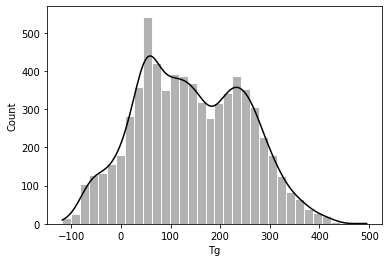

In [15]:
sns.histplot( Tg, kde=True, color = 'black', alpha = 0.3, edgecolor='white')

In [16]:
Y_trans = qt.fit(Tg.to_frame()).transform(Tg.to_frame())

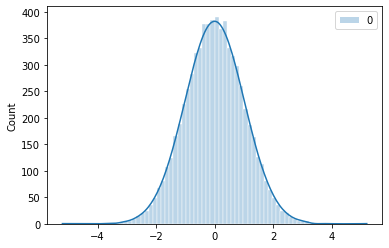

In [17]:
sns.histplot( Y_trans, kde=True, color = 'black', alpha = 0.3, edgecolor='white')

In [36]:
Tg = Dataset1_Smiles_Tg['Tg']

In [97]:
alpha = 0.1
model = Lasso(alpha=alpha)

X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

scores = cross_validate(model, X_train, y_train, cv=5,
                        scoring=('r2', 'neg_mean_absolute_error','neg_root_mean_squared_error'),
                        return_train_score=True)

print('Average train_r2', round(scores['train_r2'].mean(),2))
print('Average train_MAE', round(abs(scores['train_neg_mean_absolute_error'].mean()),2))
print('Average train_RMSE', round(abs(scores['train_neg_root_mean_squared_error'].mean()),2))

model.fit(X_train, y_train)

y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.4f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

y_dataset_2 = model.predict((X_dataset_2))
print("Dataset2 R^2: ", r2_score(ID_noTg_pred['MD'], y_dataset_2))
print("Dataset2 MAE score: %.4f" % mean_absolute_error(ID_noTg_pred['MD'], y_dataset_2))
print("Dataset2 RMSE score: %.4f" % np.sqrt(mean_squared_error(ID_noTg_pred['MD'], y_dataset_2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538175.3885098342, tolerance: 5172.307322160397
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132799.48609285057, tolerance: 5216.773426251308
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39556.77542428486, tolerance: 5213.1458587064935
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Average train_r2 0.73
Average train_MAE 42.92
Average train_RMSE 55.97


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277074.8525366243, tolerance: 6541.139163710228
  positive)


Train set R^2:  0.7332400514131094
Train MAE score: 43.0395
Train RMSE score: 56.1320
Test set R^2:  0.7338166643679842
Test MAE score: 43.0769
Test RMSE score: 57.2014
Dataset2 R^2:  0.5696735063923135
Dataset2 MAE score: 56.1759
Dataset2 RMSE score: 73.0209


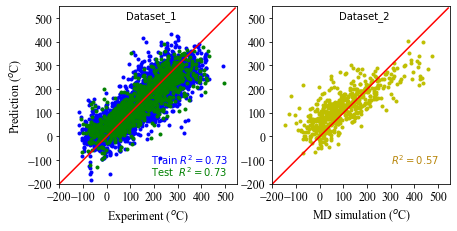

In [98]:
plt.figure(figsize=(7,14))

ax=plt.subplot(1, 2, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("Experiment ($^o$C)",fontname="Times New Roman", fontsize=12)
plt.ylabel("Prediction ($^o$C)",fontname="Times New Roman", fontsize=12)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-200, 550])
plt.ylim([-200, 550])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=12, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=12, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
plt.text(185, -118, "Train $R^2={:.2f}$".format(round(scores['train_r2'].mean(),2)),{'color':"b"})
plt.text(185, -166, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':"g"})
plt.text(80, 500, "Dataset_1")

ax=plt.subplot(1, 2, 2)
#plt.plot(y, y_pred_train, 'b.') 
plt.plot(ID_noTg_pred['MD'], y_dataset_2, 'y.') 
plt.xlabel("MD simulation ($^o$C)",fontname="Times New Roman", fontsize=12)
#plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-200, 550])
plt.ylim([-200, 550])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=12)
plt.yticks(fontname="Times New Roman", fontsize=12)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
plt.text(300, -118, "$R^2={:.2f}$".format(round(r2_score(ID_noTg_pred['MD'], y_dataset_2),2)),{'color':"darkgoldenrod"})
plt.text(80, 500, "Dataset_2")
plt.savefig("../Benchmark_Paper/Smiles_Fingerprint_Lasso.png", dpi=600, bbox_inches='tight') 

In [37]:
# hyperparameters
X_dataset_1, Tg = shuffle(X_dataset_1, Tg, random_state=0)
alpha = 0.1
cv = 10
# build model
model = Lasso(alpha=alpha).fit(X_dataset_1[:5600], Tg[:5600])
# get prediction
Tg_pred = cross_val_predict(model, X_dataset_1[:5600], Tg[:5600], cv=cv) # cross-validation
# calculate the metrics
final_R2 = r2_score(Tg[:5600],Tg_pred)
final_MAE = mean_absolute_error(Tg[:5600],Tg_pred)
# metrics of the score
scores = cross_validate(model, X_dataset_1[:5600], Tg[:5600], cv=cv,
scoring=('r2', 'neg_mean_absolute_error'),return_train_score=True)
# save the score
score_df = pd.DataFrame.from_dict(scores)
# save the model
#pickle.dump(model, open("./LASSO.model", 'wb'))
wts = model.coef_
#np.savetxt("./weights.txt", wts, fmt="%5.3f")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104792.16711119376, tolerance: 6723.157167479421
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86404.74881475233, tolerance: 6092.677497765714
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26961.66310959868, tolerance: 6079.969833099359
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65035.04633418145, tolerance: 1393.5173560371095
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205218.71876885346, tolerance: 1378.45880755379
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34111.88121691765, tolerance: 1363.5743733440002
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

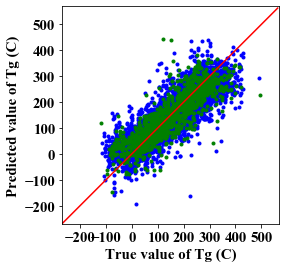

In [38]:
# plot the result
ax=plt.subplot(1, 1, 1)
plt.plot(Tg[:5600],Tg_pred, 'b.')
plt.plot(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv), 'g.')
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = -200, 500
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
#plt.text(x_end - 0.4*length, x_start + 0.10*length, "$R^2={:.2f}$".format(final_R2))
#plt.text(x_end - 0.4*length, x_start + 0.05*length, "MAE={:.2f}".format(final_MAE))
#plt.savefig("./LASSO_cv_fingerprint.png", dpi=600, bbox_inches='tight')
plt.savefig("LASSO_cv_fingerprint.svg", bbox_inches='tight')
plt.show()

In [39]:
print('Training R2:',r2_score(Tg[:5600],Tg_pred[:5600]))
print('Training MAE:',mean_absolute_error(Tg[:5600],Tg_pred[:5600]))
print('Test R2:',r2_score(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv)))
print('Test MAE:',mean_absolute_error(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv)))

Training R2: 0.737047430443974
Training MAE: 42.546043204942286


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65035.04633418145, tolerance: 1393.5173560371095
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205218.71876885346, tolerance: 1378.45880755379
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34111.88121691765, tolerance: 1363.5743733440002
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Test R2: 0.7258600048746593


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65035.04633418145, tolerance: 1393.5173560371095
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205218.71876885346, tolerance: 1378.45880755379
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34111.88121691765, tolerance: 1363.5743733440002
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Test MAE: 41.943619585194604


Train set R^2:  0.7500085413933699
Train MAE score: 39.6887


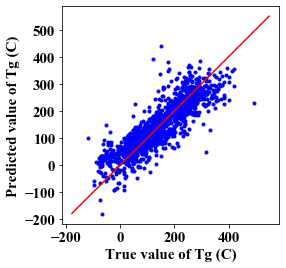

In [41]:
y_pred_train = model.predict(X_dataset_1[5600:])
y_train = Tg[5600:]

#y_pred_test = df[df['MD']<1000][df['MD']>-150]['Tg_pred_Lasso_finger']
#y_test = df[df['MD']<1000][df['MD']>-150]['MD']

print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

#print("Test set R^2: ", r2_score(y_test, y_pred_test))
#print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
#plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
#plt.xlim([x_start, x_end])
#plt.ylim([x_start, x_end])
#ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

Train set R^2:  0.5822045551314464
Train MAE score: 55.2428


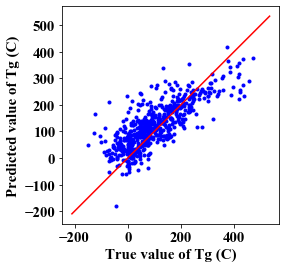

In [40]:
y_pred_train = model.predict(X_dataset_2)
y_train = ID_noTg_pred['MD']

#y_pred_test = df[df['MD']<1000][df['MD']>-150]['Tg_pred_Lasso_finger']
#y_test = df[df['MD']<1000][df['MD']>-150]['MD']

print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

#print("Test set R^2: ", r2_score(y_test, y_pred_test))
#print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
#plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
#plt.xlim([x_start, x_end])
#plt.ylim([x_start, x_end])
#ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

In [20]:
weights_df = pd.DataFrame()

In [21]:
weights_df['descriptor_id'] = Zero_Sum[Zero_Sum < NumberOfZero].index
weights_df['wt'] = wts
weights_df['abswt'] = abs(wts)

# find the main feature
coeffs = abs(wts)
coeffs = coeffs/sum(coeffs)
weights_df['ratio'] = coeffs

ordered_wts = weights_df.sort_values(['ratio'], ascending=0)
# add cumulative sum
ordered_wts['cumsum'] = ordered_wts['ratio'].to_numpy().cumsum()
ordered_wts[ordered_wts['cumsum'] <0.8]

print(ordered_wts)
print(Corr_df)

     descriptor_id         wt      abswt     ratio    cumsum
84           16406  30.326958  30.326958  0.044004  0.044004
89           17748  29.773489  29.773489  0.043201  0.087206
114          24417 -25.499196  25.499196  0.036999  0.124205
46            7968  24.131836  24.131836  0.035015  0.159220
2              426  24.117823  24.117823  0.034995  0.194215
..             ...        ...        ...       ...       ...
92           18464  -0.000000   0.000000  0.000000  1.000000
61           11555  -0.000000   0.000000  0.000000  1.000000
31            4660   0.000000   0.000000  0.000000  1.000000
98           21179  -0.000000   0.000000  0.000000  1.000000
62           11856  -0.000000   0.000000  0.000000  1.000000

[124 rows x 5 columns]
       index           0
0          0  4093640732
1          1   687341608
2          2  3670016041
3          3   583794733
4          4  1563557952
...      ...         ...
26451  26451   351010789
26452  26452   563085300
26453  26453   5785

In [22]:
ordered_wts[ordered_wts['cumsum'] <0.8]

,descriptor_id,wt,abswt,ratio,cumsum
84,16406,30.326958,30.326958,0.044004,0.044004
89,17748,29.773489,29.773489,0.043201,0.087206
114,24417,-25.499196,25.499196,0.036999,0.124205
46,7968,24.131836,24.131836,0.035015,0.159220
2,426,24.117823,24.117823,0.034995,0.194215
110,24060,21.368356,21.368356,0.031005,0.225220
4,770,-19.587993,19.587993,0.028422,0.253642
104,22566,18.040026,18.040026,0.026176,0.279818
88,17618,17.323779,17.323779,0.025137,0.304955
60,11362,16.660818,16.660818,0.024175,0.329130


#### plot substructure

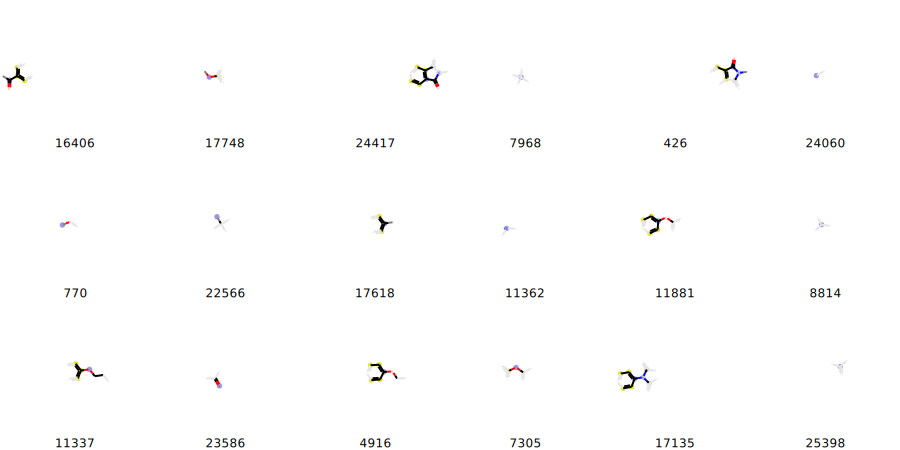

In [24]:
# Save as svg file for high resolution
tpls = []
Num = 0
for x in ordered_wts['descriptor_id'][:18]:
    for i in range(len(fp_n)):
        Code = (Corr_df[Corr_df['index'] == x][0].values[0])
        if Code in fp_n.iloc[i].keys():
            mol = Chem.MolFromSmiles(Dataset1_Smiles_Tg.Smiles.iloc[i]) 
            bi = {}
            fp = rdMolDescriptors.GetMorganFingerprint(mol, radius=3, bitInfo=bi)
            tpls.append((mol,Code,bi))
            img = Draw.DrawMorganBit(mol,Code,bi, useSVG=True)
            with open('FrequentFingerprint_{}'.format(Num)+'_{}.svg'.format(x), 'w') as f_handle:
                f_handle.write(img.data)                        
            Num = Num + 1
            break
            
            
img = Draw.DrawMorganBits(tpls,molsPerRow=6,legends=[str(x) for x in ordered_wts['descriptor_id'][:18]], useSVG=True)
with open('FrequentFingerprint_all.svg', 'w') as f_handle:
    f_handle.write(img.data)
img

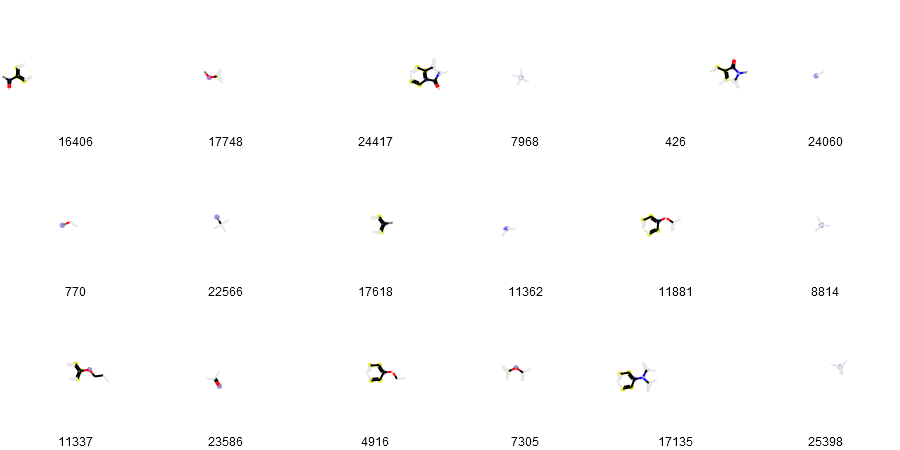

In [25]:
# Save as png file
tpls = []
Num = 0
for x in ordered_wts['descriptor_id'][:18]:
    for i in range(len(fp_n)):
        Code = (Corr_df[Corr_df['index'] == x][0].values[0])
        if Code in fp_n.iloc[i].keys():
            mol = Chem.MolFromSmiles(Dataset1_Smiles_Tg.Smiles.iloc[i]) 
            bi = {}
            fp = rdMolDescriptors.GetMorganFingerprint(mol, radius=3, bitInfo=bi)
            tpls.append((mol,Code,bi))
            img = Draw.DrawMorganBit(mol,Code,bi)
            img.save('FrequentFingerprint_{}'.format(Num)+'_{}.png'.format(x))
            Num = Num + 1
            break
            
            
img = Draw.DrawMorganBits(tpls,molsPerRow=6,legends=[str(x) for x in ordered_wts['descriptor_id'][:18]])
img.save('FrequentFingerprint_{}'.format(Num)+'_{}.png'.format(x))
img

### CNN

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
def encoding(df):
  encoded=[]
  elements = [['c'], ['n'], ['o'], ['C'], ['N'], ['F'], ['='], ['O'], 
              ['('], [')'], ['*'],['['], [']'], ['1'], ['2'],['3'],['#'],['Cl'],['/'],['S'],['Br']]
  

  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(elements)
  enc.categories_
  df1=df["Smiles"].apply(lambda x: pd.Series(list(x)))
  for i in range(df1.shape[0]):
    x=enc.transform(pd.DataFrame(df1.iloc[i,:]).dropna(how="all").values).toarray()
    y=np.zeros(((df1.shape[1]-x.shape[0]),len(elements)))
    encoded.append(np.vstack((x,y)))
  return encoded

def encoded_generate_images(df):
  listt=encoding(df)
  plt.figure(figsize=(20,100))
  for i in range(len(listt)):
    plt.subplot(len(listt),5,i+1)
    plt.imshow(listt[i])

In [62]:
X_all = encoding(ID_noTg_pred)
X_2 = np.array(X_all)


In [63]:
X_2.shape

(566, 209, 21)

In [ ]:
X = X.reshape((6923, 310, 21, 1))
X.shape

In [51]:
#X=encoding(df.iloc[:100])
X_all=encoding(Dataset1_Smiles_Tg)
X=np.array(X_all[:6923])
X = X.reshape((6923, 310, 21, 1))
X.shape

(6923, 310, 21, 1)

In [52]:
Y=Dataset1_Smiles_Tg["Tg"].values
Y.shape

(6923,)

                                                 Smiles           ID       id  \
6130  *N1C(=O)C2C3C4C(C(C2C1=O)C=C3)C(=O)N(C4=O)c1cc...  P433282.mol  P433282   
6131  *N1C(=O)C2C3C4C(C(C2C1=O)C=C3)C(=O)N(C4=O)c1cc...  P433283.mol  P433283   
6132  *N1C(=O)c2c(C1=O)cc(cc2)Oc1cc2c(C(=O)N(C2=O)c2...  P433284.mol  P433284   
6133  *N1C(=O)c2c(C1=O)cc(cc2)Oc1cc2c(C(=O)N(C2=O)c2...  P433285.mol  P433285   
6134  *N1C(=O)c2c(C1=O)cc(cc2)Oc1cc2c(C(=O)N(C2=O)c2...  P433286.mol  P433286   
6135  *N1C(=O)c2c(C1=O)cc(cc2)Oc1cc2c(C(=O)N(C2=O)c2...  P433287.mol  P433287   
6136  *N1C(=O)c2c(C1=O)cc(cc2)Oc1cc2c(C(=O)N(C2=O)c2...  P433292.mol  P433292   
6137  *c1cc2c(C(=O)N(C2=O)c2ccc(cc2)Oc2ccc(cc2)C(=O)...  P433293.mol  P433293   
6138  *c1cc2c(C(=O)N(C2=O)c2ccc(cc2)Oc2ccc(cc2)C(=O)...  P433294.mol  P433294   
6139  *N1C(=O)C(CC1=O)(SCCOCCSC1(C(=O)N(C(=O)C1)CCCC...  P433302.mol  P433302   

                                                 SMILES     Tg  
6130  CCc1ccc(N2C(=O)c3cc(Sc4ccccc4)c(Sc4cc

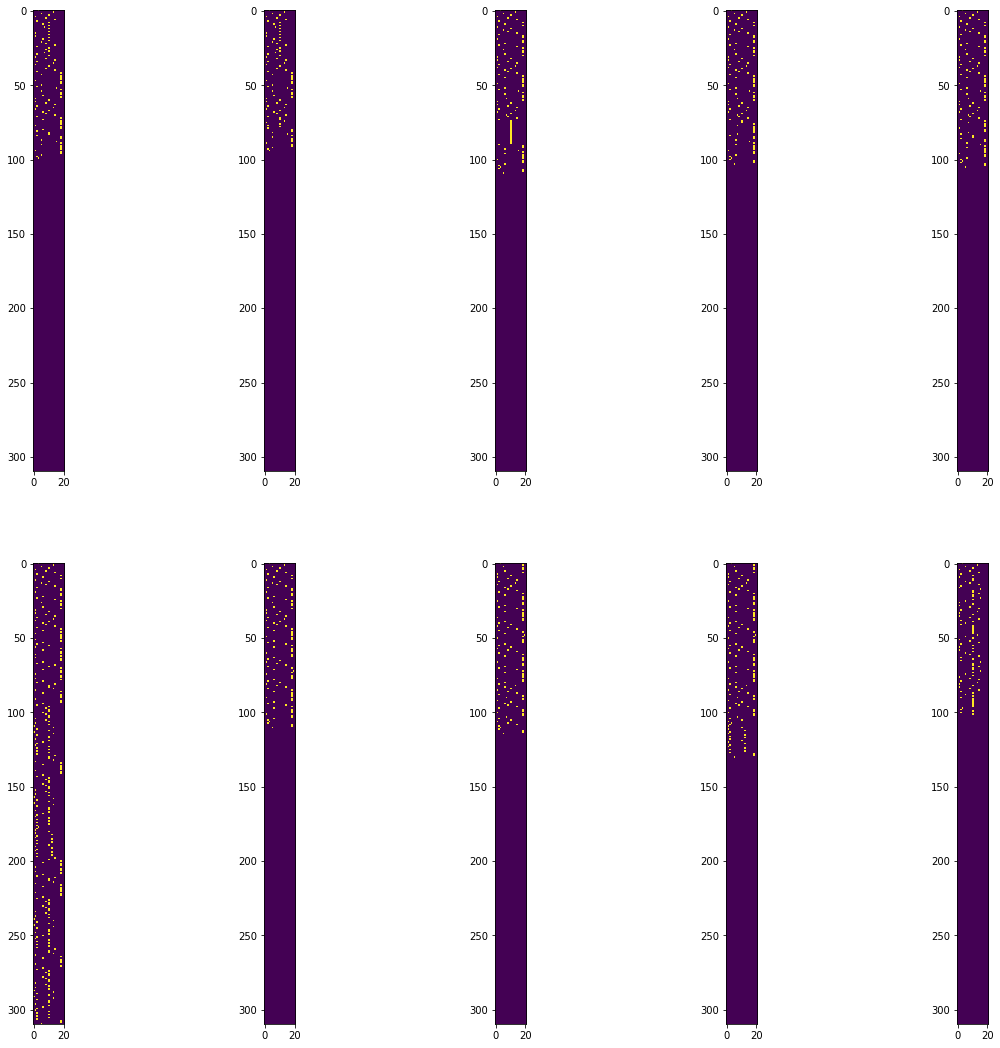

In [53]:
print(Dataset1_Smiles_Tg.iloc[6130:6140])
encoded_generate_images(Dataset1_Smiles_Tg.iloc[6130:6140])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
model = Sequential()
model.add(Conv2D(8, (10, 10), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(8, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=75,batch_size=16,validation_split=0.2)

Epoch 1/75
312/312 [==============================] - ETA: 0s - loss: 173.017 - ETA: 1s - loss: 115.731 - ETA: 0s - loss: 103.218 - ETA: 0s - loss: 96.428 - ETA: 0s - loss: 91.82 - ETA: 0s - loss: 87.38 - ETA: 0s - loss: 84.32 - ETA: 0s - loss: 82.50 - ETA: 0s - loss: 79.97 - ETA: 0s - loss: 77.92 - ETA: 0s - loss: 76.52 - ETA: 0s - loss: 74.83 - ETA: 0s - loss: 73.53 - ETA: 0s - loss: 72.39 - ETA: 0s - loss: 71.60 - ETA: 0s - loss: 70.63 - ETA: 0s - loss: 69.78 - ETA: 0s - loss: 69.11 - ETA: 0s - loss: 68.27 - ETA: 0s - loss: 68.14 - 1s 4ms/step - loss: 68.1446 - val_loss: 57.1607
Epoch 2/75
312/312 [==============================] - ETA: 0s - loss: 51.40 - ETA: 0s - loss: 52.88 - ETA: 0s - loss: 54.78 - ETA: 0s - loss: 55.17 - ETA: 0s - loss: 54.84 - ETA: 0s - loss: 55.21 - ETA: 0s - loss: 54.18 - ETA: 0s - loss: 53.38 - ETA: 0s - loss: 53.34 - ETA: 0s - loss: 53.07 - ETA: 0s - loss: 52.79 - ETA: 0s - loss: 52.63 - ETA: 0s - loss: 52.18 - ETA: 0s - loss: 52.28 - ETA: 0s - loss: 52.09

312/312 [==============================] - ETA: 0s - loss: 40.75 - ETA: 0s - loss: 33.05 - ETA: 0s - loss: 30.91 - ETA: 0s - loss: 30.09 - ETA: 0s - loss: 29.87 - ETA: 0s - loss: 30.35 - ETA: 0s - loss: 30.26 - ETA: 0s - loss: 30.38 - ETA: 0s - loss: 30.44 - ETA: 0s - loss: 30.68 - ETA: 0s - loss: 30.55 - ETA: 0s - loss: 30.79 - 1s 2ms/step - loss: 30.7701 - val_loss: 33.1416
Epoch 37/75
312/312 [==============================] - ETA: 0s - loss: 32.57 - ETA: 0s - loss: 31.99 - ETA: 0s - loss: 30.68 - ETA: 0s - loss: 29.62 - ETA: 0s - loss: 29.55 - ETA: 0s - loss: 29.61 - ETA: 0s - loss: 29.78 - ETA: 0s - loss: 29.99 - ETA: 0s - loss: 29.58 - ETA: 0s - loss: 29.54 - ETA: 0s - loss: 29.62 - ETA: 0s - loss: 29.70 - 1s 2ms/step - loss: 29.9507 - val_loss: 32.6060
Epoch 38/75
312/312 [==============================] - ETA: 0s - loss: 26.86 - ETA: 0s - loss: 29.26 - ETA: 0s - loss: 30.24 - ETA: 0s - loss: 30.33 - ETA: 0s - loss: 30.20 - ETA: 0s - loss: 29.87 - ETA: 0s - loss: 29.45 - ETA: 0s

In [59]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
MAE_test=abs(y_predtest.reshape(y_test.shape)-y_test).sum()/y_test.shape
MAE_train=abs(y_predtrain.reshape(y_train.shape)-y_train).sum()/y_train.shape
print("Mean Absolute Error on Training Set = ",MAE_train.item())
print("Mean Absolute Error on Test Set = ",MAE_test.item())

Mean Absolute Error on Training Set =  23.837268092489936
Mean Absolute Error on Test Set =  31.480019543428956


In [61]:
from sklearn.metrics import r2_score
print(r2_score(y_predtrain,y_train.reshape(6230,1)))
print(r2_score(y_predtest,y_test.reshape(693,1)))

0.8858038249798458
0.8057422254794662


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_predtrain,y_train.reshape(6230,1)))
print(r2_score(y_predtest,y_test.reshape(693,1)))

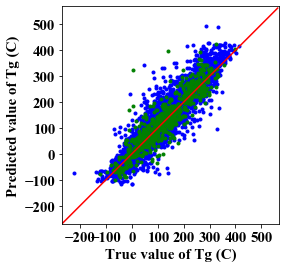

In [74]:
ax=plt.subplot(1, 1, 1)
plt.plot(y_predtrain, y_train.reshape(6230,1), 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, y_pred_train)))
plt.plot(y_predtest, y_test.reshape(693,1), 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, y_pred_test)))
#plt.legend(loc = 'best')
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = -200, 500
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
#plt.text(x_end - 0.4*length, x_start + 0.10*length, "$R^2={:.2f}$".format(final_R2))
#plt.text(x_end - 0.4*length, x_start + 0.05*length, "MAE={:.2f}".format(final_MAE))
#plt.savefig("./CNN_image.png", dpi=600, bbox_inches='tight')
#plt.savefig("CNN_image.svg", bbox_inches='tight')

### RandomForestRegressor

In [36]:
X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [37]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Train set R^2:  0.9806556271051803
Train MAE score: 9.9111
Test set R^2:  0.8783762593210919
Test MAE score: 26.3666


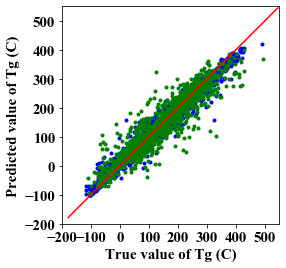

In [38]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### DNN

In [28]:
X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [18]:
# X = X_dataset_1
# y = Dataset1_Smiles_Tg['Tg']

# Y_trans = qt.fit(y.to_frame()).transform(y.to_frame())

# X_train, X_test, y_train, y_test = train_test_split(X, Y_trans, 
#                                                     test_size=0.2, 
#                                                     random_state=2)

In [29]:
model = keras.models.Sequential()
model.add(Dense(units = 8, input_dim = X.shape[1],activation='relu'))
model.add(Dense(units = 8, activation='relu'))
model.add(Dense(units = 1))
 
# model.summary()

model.compile(loss = 'mean_squared_error',
    optimizer = 'adam')
history = model.fit((X_train), y_train, epochs = 100, batch_size = 32,
    validation_data = ((X_test), y_test), verbose=2)

Epoch 1/100
174/174 - 0s - loss: 27382.0098 - val_loss: 17463.9336
Epoch 2/100
174/174 - 0s - loss: 9748.4824 - val_loss: 7487.9502
Epoch 3/100
174/174 - 0s - loss: 6496.9932 - val_loss: 6243.8281
Epoch 4/100
174/174 - 0s - loss: 5478.3096 - val_loss: 5357.1421
Epoch 5/100
174/174 - 0s - loss: 4774.2661 - val_loss: 4659.9478
Epoch 6/100
174/174 - 0s - loss: 4241.1865 - val_loss: 4110.6143
Epoch 7/100
174/174 - 0s - loss: 3794.8845 - val_loss: 3721.5542
Epoch 8/100
174/174 - 0s - loss: 3477.0830 - val_loss: 3422.8188
Epoch 9/100
174/174 - 0s - loss: 3245.6458 - val_loss: 3221.6221
Epoch 10/100
174/174 - 0s - loss: 3102.1931 - val_loss: 3074.6411
Epoch 11/100
174/174 - 0s - loss: 2994.6299 - val_loss: 2982.3218
Epoch 12/100
174/174 - 0s - loss: 2911.8418 - val_loss: 2915.1567
Epoch 13/100
174/174 - 0s - loss: 2859.6855 - val_loss: 2877.0579
Epoch 14/100
174/174 - 0s - loss: 2796.9734 - val_loss: 2855.6128
Epoch 15/100
174/174 - 0s - loss: 2758.8545 - val_loss: 2826.0415
Epoch 16/100
174/

Train set R^2:  0.8485783881698115
Train MAE score: 30.3966
Test set R^2:  0.825927232091195
Test MAE score: 33.0013


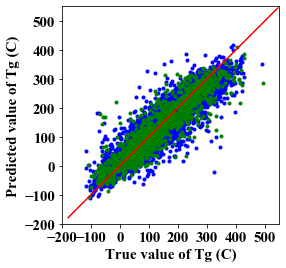

In [30]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

Train set R^2:  0.6570555636763277
Train MAE score: 48.3437


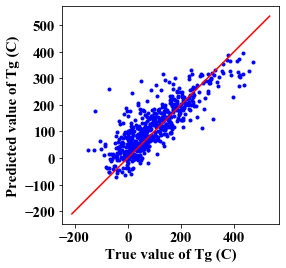

In [31]:
y_pred_train = model.predict(X_dataset_2)
y_train = ID_noTg_pred['MD']

#y_pred_test = df[df['MD']<1000][df['MD']>-150]['Tg_pred_Lasso_finger']
#y_test = df[df['MD']<1000][df['MD']>-150]['MD']

print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

#print("Test set R^2: ", r2_score(y_test, y_pred_test))
#print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
#plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
#plt.xlim([x_start, x_end])
#plt.ylim([x_start, x_end])
#ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

Train set R^2:  0.9806556271051803
Train MAE score: 9.9111
Test set R^2:  0.8783762593210919
Test MAE score: 26.3666


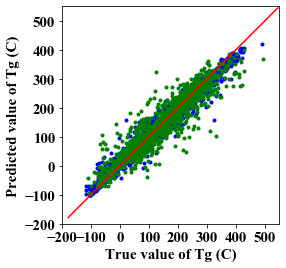

In [21]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

Train set R^2:  0.5925005605056114
Train MAE score: 54.3140


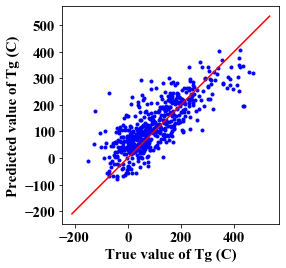

In [22]:
y_pred_train = model.predict(X_dataset_2)
y_train = ID_noTg_pred['MD']

#y_pred_test = df[df['MD']<1000][df['MD']>-150]['Tg_pred_Lasso_finger']
#y_test = df[df['MD']<1000][df['MD']>-150]['MD']

print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

#print("Test set R^2: ", r2_score(y_test, y_pred_test))
#print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
#plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
#plt.xlim([x_start, x_end])
#plt.ylim([x_start, x_end])
#ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

In [23]:
from sklearn.svm import SVR

In [25]:
X = X_dataset_1
y = Dataset1_Smiles_Tg['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

Train set R^2:  0.7378840476596997
Train MAE score: 40.7238
Test set R^2:  0.744695081466954
Test MAE score: 41.1436


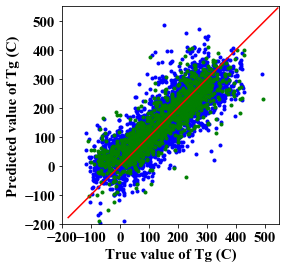

In [26]:

model = SVR(kernel = 'linear')
model.fit(X_train, y_train)

y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

Train set R^2:  0.56314491768984
Train MAE score: 56.1753


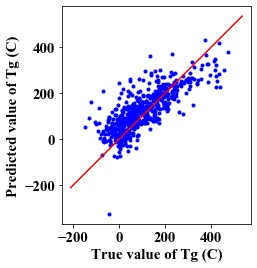

In [27]:
y_pred_train = model.predict(X_dataset_2)
y_train = ID_noTg_pred['MD']

#y_pred_test = df[df['MD']<1000][df['MD']>-150]['Tg_pred_Lasso_finger']
#y_test = df[df['MD']<1000][df['MD']>-150]['MD']

print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

#print("Test set R^2: ", r2_score(y_test, y_pred_test))
#print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
#plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
#plt.xlim([x_start, x_end])
#plt.ylim([x_start, x_end])
#ax.set_xticks([-200,-100,0,100,200,300,400,500])
#ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

# Embedding

In [5]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [4]:
Dataset1_Smiles_Tg

,Smiles,ID,id,SMILES,Tg
0,*C*,P010001.mol,P010001,CC,-63.48
1,*C(C*)C,P010002.mol,P010002,CCC,-2.73
2,*C(C*)CC,P010003.mol,P010003,CCCC,-22.54
3,*C(C*)CCC,P010004.mol,P010004,CCCCC,-32.29
4,*C(C*)C(C)C,P010006.mol,P010006,CCC(C)C,10.97
...,...,...,...,...,...
6918,*C1C(CC(C1)C(O)(C(F)(F)F)C(F)(F)F)(C(C*)(F)F)F,P522048.mol,P522048,CC(F)(F)C1(F)CCC(C(O)(C(F)(F)F)C(F)(F)F)C1,118.00
6919,*c1cc2C3(CCC(CC3)(C3=NC(CO3)c3ccccc3)C3=NC(CO3...,P522049.mol,P522049,CCCCCCC1(CCCCCC)c2ccccc2-c2ccc(-c3ccc4c(c3)C3(...,161.00
6920,*c1cc2C3(CCC(CC3)(C3=NC(CO3)Cc3ccccc3)C3=NC(CO...,P522050.mol,P522050,CCCCCCC1(CCCCCC)c2ccccc2-c2ccc(-c3ccc4c(c3)C3(...,142.00
6921,*C(C*)(C(=O)OCC(Cl)(Cl)Cl)F,P522055.mol,P522055,CC(F)C(=O)OCC(Cl)(Cl)Cl,127.00


In [6]:
DF = Dataset1_Smiles_Tg.copy()

In [41]:
molecules = DF.Smiles.apply(Chem.MolFromSmiles)
DF['molecules'] = molecules
DF = DF.dropna()

In [42]:
model = word2vec.Word2Vec.load('../mol2vec-master/examples/models/model_300dim.pkl')

In [43]:
df = pd.DataFrame()

In [44]:
df['sentence'] = DF.apply(lambda x: MolSentence(mol2alt_sentence(x['molecules'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

In [45]:
a = df['sentence'][0]
a.sentence

['2342113506',
 '1302073591',
 '2245384272',
 '915669106',
 '2342113506',
 '1302073591']

In [111]:
X = np.array([x.vec for x in df['mol2vec']])

In [112]:
X.shape

(6923, 300)

In [144]:
Tg = DF['Tg']

In [145]:
# hyperparameters
X_dataset_1, Tg = shuffle(X, Tg, random_state=0)
alpha = 0.1
cv = 10
# build model
model = Lasso(alpha=alpha).fit(X_dataset_1[:5600], Tg[:5600])
# get prediction
Tg_pred = cross_val_predict(model, X_dataset_1[:5600], Tg[:5600], cv=cv) # cross-validation
# calculate the metrics
final_R2 = r2_score(Tg[:5600],Tg_pred)
final_MAE = mean_absolute_error(Tg[:5600],Tg_pred)
# metrics of the score
scores = cross_validate(model, X_dataset_1[:5600], Tg[:5600], cv=cv,
scoring=('r2', 'neg_mean_absolute_error'),return_train_score=True)
# save the score
score_df = pd.DataFrame.from_dict(scores)
# save the model
#pickle.dump(model, open("./LASSO.model", 'wb'))
wts = model.coef_
#np.savetxt("./weights.txt", wts, fmt="%5.3f")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6044684.5, tolerance: 6723.15673828125
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5541354.5, tolerance: 6092.67724609375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5079455.0, tolerance: 6079.9697265625
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5214657.0, tolerance: 60

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876765.6875, tolerance: 1393.517333984375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 986140.1875, tolerance: 1378.458740234375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 992522.4375, tolerance: 1363.5743408203125
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952672.1875, 

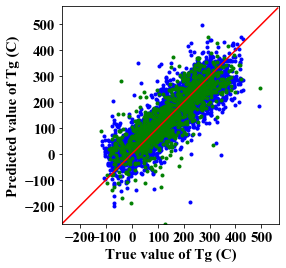

In [146]:
# plot the result
ax=plt.subplot(1, 1, 1)
plt.plot(Tg[:5600],Tg_pred, 'b.')
plt.plot(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv), 'g.')
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = -200, 500
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')
#plt.text(x_end - 0.4*length, x_start + 0.10*length, "$R^2={:.2f}$".format(final_R2))
#plt.text(x_end - 0.4*length, x_start + 0.05*length, "MAE={:.2f}".format(final_MAE))
#plt.savefig("./LASSO_cv_fingerprint.png", dpi=600, bbox_inches='tight')
#plt.savefig("LASSO_cv_fingerprint.svg", bbox_inches='tight')
plt.show()

In [147]:
print('Training R2:',r2_score(Tg[:5600],Tg_pred[:5600]))
print('Training MAE:',mean_absolute_error(Tg[:5600],Tg_pred[:5600]))
print('Test R2:',r2_score(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv)))
print('Test MAE:',mean_absolute_error(Tg[5600:],cross_val_predict(model, X_dataset_1[5600:], Tg[5600:], cv=cv)))

Training R2: 0.757379133063672
Training MAE: 40.53283338748387


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876765.6875, tolerance: 1393.517333984375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 986140.1875, tolerance: 1378.458740234375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 992522.4375, tolerance: 1363.5743408203125
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952672.1875, 

Test R2: 0.6548335082418115


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876765.6875, tolerance: 1393.517333984375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 986140.1875, tolerance: 1378.458740234375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 992522.4375, tolerance: 1363.5743408203125
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952672.1875, 

Test MAE: 44.23118567757235


### GaussianProcessRegressor

In [132]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [137]:
y = DF['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [140]:
kernel = RBF()

In [141]:
model = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Train set R^2:  0.9999932818024658
Train MAE score: 0.0108
Test set R^2:  -1.5185858235420158
Test MAE score: 145.6085


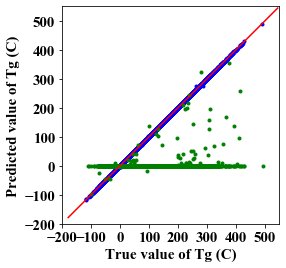

In [142]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

In [ ]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=20,
              param_grid={"alpha": np.logspace(-15, -10, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)
GPmodel = GPmodel.fit(X, y)

### DNN

In [48]:
y = DF['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [49]:
model = keras.models.Sequential()
model.add(Dense(units = 8, input_dim = X.shape[1],activation='relu'))
model.add(Dense(units = 8, activation='relu'))
model.add(Dense(units = 1))
 
# model.summary()

model.compile(loss = 'mean_squared_error',
    optimizer = 'adam')
history = model.fit((X_train), y_train, epochs = 100, batch_size = 32,
    validation_data = ((X_test), y_test), verbose=2)

Epoch 1/100
174/174 - 0s - loss: 26080.4512 - val_loss: 11667.5400
Epoch 2/100
174/174 - 0s - loss: 8273.1719 - val_loss: 7728.5146
Epoch 3/100
174/174 - 0s - loss: 7055.9053 - val_loss: 7062.9185
Epoch 4/100
174/174 - 0s - loss: 6087.4150 - val_loss: 5730.8013
Epoch 5/100
174/174 - 0s - loss: 5159.8828 - val_loss: 4977.6079
Epoch 6/100
174/174 - 0s - loss: 4633.5625 - val_loss: 4653.7627
Epoch 7/100
174/174 - 0s - loss: 4358.0894 - val_loss: 4311.4561
Epoch 8/100
174/174 - 0s - loss: 4171.2793 - val_loss: 4161.9307
Epoch 9/100
174/174 - 0s - loss: 4070.3647 - val_loss: 4072.7141
Epoch 10/100
174/174 - 0s - loss: 3983.0112 - val_loss: 4021.2012
Epoch 11/100
174/174 - 0s - loss: 3935.9949 - val_loss: 3930.5503
Epoch 12/100
174/174 - 0s - loss: 3885.3291 - val_loss: 3879.5227
Epoch 13/100
174/174 - 0s - loss: 3906.3521 - val_loss: 3841.0996
Epoch 14/100
174/174 - 0s - loss: 3796.0696 - val_loss: 3825.7717
Epoch 15/100
174/174 - 0s - loss: 3779.9011 - val_loss: 3783.4336
Epoch 16/100
174/

Train set R^2:  0.7618433743139
Train MAE score: 40.2213
Test set R^2:  0.760306930563054
Test MAE score: 41.0237


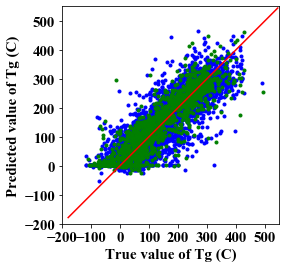

In [50]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### CNN

In [80]:
from keras import optimizers

In [95]:
X = X.reshape((6923, 300, 1))

In [103]:
y = DF['Tg']
y = np.array(y).reshape((6923, 1))

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [105]:
X_train.shape

(5538, 300, 1)

In [106]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=8, activation='relu', kernel_regularizer="l2", input_shape=(300, 1)))
#model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=50,batch_size=16,validation_split=0.2)

Epoch 1/50
277/277 [==============================] - ETA: 0s - loss: 123.139 - ETA: 0s - loss: 79.485 - ETA: 0s - loss: 72.70 - ETA: 0s - loss: 67.68 - ETA: 0s - loss: 64.27 - ETA: 0s - loss: 61.95 - ETA: 0s - loss: 60.36 - ETA: 0s - loss: 58.51 - ETA: 0s - loss: 57.18 - 1s 2ms/step - loss: 56.6061 - val_loss: 45.8964
Epoch 2/50
277/277 [==============================] - ETA: 0s - loss: 54.13 - ETA: 0s - loss: 46.98 - ETA: 0s - loss: 46.56 - ETA: 0s - loss: 45.43 - ETA: 0s - loss: 45.10 - ETA: 0s - loss: 45.27 - ETA: 0s - loss: 45.07 - ETA: 0s - loss: 44.73 - ETA: 0s - loss: 44.39 - 1s 2ms/step - loss: 44.5527 - val_loss: 46.5582
Epoch 3/50
277/277 [==============================] - ETA: 0s - loss: 44.06 - ETA: 0s - loss: 45.52 - ETA: 0s - loss: 43.19 - ETA: 0s - loss: 42.22 - ETA: 0s - loss: 41.33 - ETA: 0s - loss: 41.36 - ETA: 0s - loss: 41.25 - ETA: 0s - loss: 41.06 - ETA: 0s - loss: 41.05 - 1s 2ms/step - loss: 40.9848 - val_loss: 39.3150
Epoch 4/50
277/277 [=======================

In [109]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 293, 8)            72        
_________________________________________________________________
dropout_5 (Dropout)          (None, 293, 8)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2344)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2345      
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________


Train set R^2:  0.8324161332372851
Train MAE score: 31.0366
Test set R^2:  0.8200907010315139
Test MAE score: 33.3515


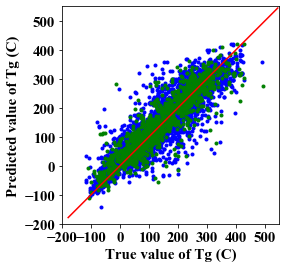

In [110]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### SVM

In [54]:
y = DF['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [72]:
from sklearn.svm import SVR
model = SVR(kernel = 'linear')
model.fit(X_train, y_train)

SVR(kernel='linear')

In [73]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Train set R^2:  0.7797651887291073
Train MAE score: 36.3532
Test set R^2:  0.7503343106525535
Test MAE score: 40.4017


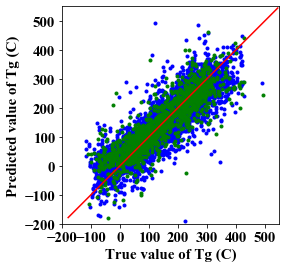

In [74]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')

### RandomForestRegressor

In [1]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
y = DF['Tg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [25]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [26]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Train set R^2:  0.9788803715005039
Train MAE score: 10.9229
Test set R^2:  0.8599919736850109
Test MAE score: 29.0031


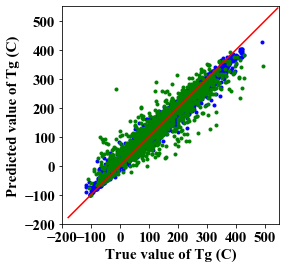

In [27]:
y_pred_train = model.predict((X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))

y_pred_test = model.predict((X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))

ax=plt.subplot(1, 1, 1)
plt.plot(y_train, y_pred_train, 'b.') 
plt.plot(y_test, y_pred_test, 'g.') 
 
plt.xlabel("True value of Tg (C)",fontname="Times New Roman", fontsize=15)
plt.ylabel("Predicted value of Tg (C)",fontname="Times New Roman", fontsize=15)
x0, x1 = min(y_train), max(y_train)
length = x1 - x0
x_start, x_end = x0-0.1*length, x1+0.1*length
plt.xlim([x_start, x_end])
plt.ylim([x_start, x_end])
ax.set_xticks([-200,-100,0,100,200,300,400,500])
ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=15)
plt.yticks(fontname="Times New Roman", fontsize=15)
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), 'r-')